In [1]:
import os
import sys
sys.path.append(os.path.abspath('../../../..'))
import numpy as np
import pandas as pd

# from utlis.corr_utlis.processed_syned_load import load_filtered_data_from_h5

rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Define head keypoints
head_keypoints = [1, 2, 3, 4]  # EarL, EarR, Snout, SpineF

# Extract the relevant coordinates
head_coords = df_merged_with_dF_F[[f"kp{idx}_{axis}" for idx in head_keypoints for axis in ['x', 'y', 'z']]].copy()

# Define labels for better readability
keypoint_labels = {
    1: 'EarL',
    2: 'EarR',
    3: 'Snout',
    4: 'SpineF'
}


In [ ]:
from adapted_try import eul2rot

def rigid_align_to_spine(df, ref_kp='kp4', axis_order='xyz'):
    """
    Rigid body transformation aligning all points relative to `ref_kp` (e.g., `spineF`).
    
    Args:
    - df: DataFrame with keypoint coordinates (e.g., kp4_x, kp4_y, kp4_z).
    - ref_kp: Reference keypoint name (e.g., 'kp4').
    - axis_order: Euler axis order for rotation ('xyz' by default).

    Returns:
    - Aligned DataFrame with points transformed to the new reference frame.
    """
    aligned_df = df.copy()

    # Extract the reference point (spineF) coordinates
    ref_x, ref_y, ref_z = df[f'{ref_kp}_x'], df[f'{ref_kp}_y'], df[f'{ref_kp}_z']
    
    # Translate all points to set `spineF` at the origin
    for col in df.columns:
        if '_x' in col:
            aligned_df[col] -= ref_x
        elif '_y' in col:
            aligned_df[col] -= ref_y
        elif '_z' in col:
            aligned_df[col] -= ref_z

    # Apply rigid body rotation if necessary (e.g., to align `spineF` to a global axis)
    # You can compute Euler angles, build a rotation matrix, and apply it to each keypoint.
    # Example placeholder:
    rotation_mat = eul2rot([0, 0, 0], order=5)  # Replace with real angles
    for kp in ['kp1', 'kp2', 'kp3']:  # Iterate over all keypoints
        points = aligned_df[[f'{kp}_x', f'{kp}_y', f'{kp}_z']].values
        aligned_df[[f'{kp}_x', f'{kp}_y', f'{kp}_z']] = points @ rotation_mat.T

    return aligned_df


In [3]:
import optitracking_lib as orig
import adaped_try_df as dfrev
import numpy as np
import pandas as pd

df_test = df_merged_with_dF_F.copy()
df_test = df_test.reset_index()

df_results = dfrev.process_tracking_data_df(
    df_test,
    spineF_kp=4,   # example keypoint indices
    tailB_kp=6,
    spineM_kp=5,
    earL_kp=1,  # Example: keypoint 1 is 'EarL'
    earR_kp=2,  # Example: keypoint 2 is 'EarR'
    snout_kp=3,
    frame_rate=30.0
)

Processing to get body-related rotation matrices from DataFrame ...
Processing head rotations from keypoints...
Computing Euler angles from the rotation matrices...


In [4]:
df_results

{'r_roots': array([[[-0.72646615, -0.68720225,  0.        ],
         [ 0.68720225, -0.72646615,  0.        ],
         [ 0.        ,  0.        ,  1.        ]],
 
        [[-0.72515149, -0.68858937,  0.        ],
         [ 0.68858937, -0.72515149,  0.        ],
         [ 0.        ,  0.        ,  1.        ]],
 
        [[-0.71475801, -0.69937185,  0.        ],
         [ 0.69937185, -0.71475801,  0.        ],
         [ 0.        ,  0.        ,  1.        ]],
 
        ...,
 
        [[ 0.73202104, -0.68128203,  0.        ],
         [ 0.68128203,  0.73202104,  0.        ],
         [ 0.        ,  0.        ,  1.        ]],
 
        [[ 0.5925091 , -0.80556375,  0.        ],
         [ 0.80556375,  0.5925091 ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]],
 
        [[ 0.74805112, -0.66364111,  0.        ],
         [ 0.66364111,  0.74805112,  0.        ],
         [ 0.        ,  0.        ,  1.        ]]]),
 'r_root_inv': array([[[-0.68466063,  0.64765622,  0.334

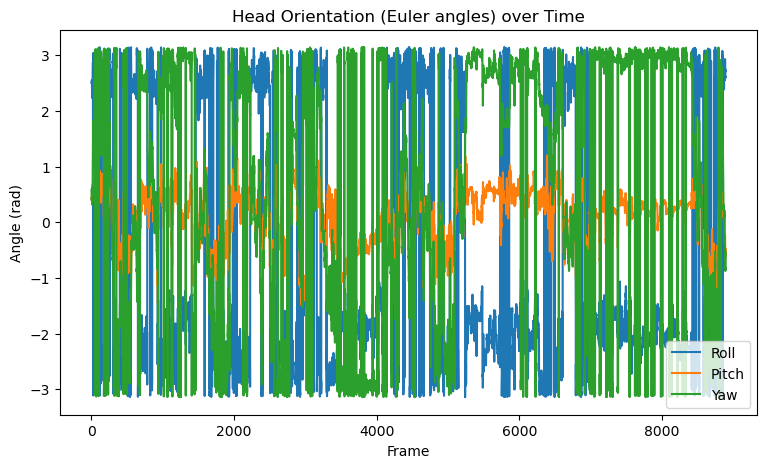

In [5]:
import numpy as np

def rotation_matrix_to_euler(R, sequence='xyz'):
    """
    Convert a 3x3 rotation matrix to Euler angles in a given sequence.
    For example, `sequence='xyz'` means Rz * Ry * Rx, etc.
    
    NOTE: There's no single standard for Euler sequences, so pick carefully.
    """
    # For brevity, here's a quick approach for 'zyx' (roll-pitch-yaw).
    # If you need a different sequence, you'll need a custom implementation or a library function.
    
    # We'll assume sequence='zyx' for the example (yaw-pitch-roll order).
    sy = np.sqrt(R[0,0]*R[0,0] + R[1,0]*R[1,0])
    singular = sy < 1e-6

    if not singular:
        # yaw (around z), pitch (around y), roll (around x)
        yaw   = np.arctan2(R[1,0], R[0,0])
        pitch = np.arctan2(-R[2,0], sy)
        roll  = np.arctan2(R[2,1], R[2,2])
    else:
        # handle singular case
        yaw   = np.arctan2(-R[1,2], R[1,1])
        pitch = np.arctan2(-R[2,0], sy)
        roll  = 0

    return np.array([roll, pitch, yaw])

nf = df_test.shape[0]
global_head_rm = df_results["global_head_rm"]
eulers_over_time = []
for t in range(nf):
    # Suppose global_head_rm[t,:,:] is the rotation matrix
    if not np.any(np.isnan(global_head_rm[t,:,:])):  # skip NaN
        eulers = rotation_matrix_to_euler(global_head_rm[t,:,:], sequence='zyx')
        eulers_over_time.append(eulers)
    else:
        eulers_over_time.append([np.nan, np.nan, np.nan])

# Convert to a NumPy array for easier slicing
eulers_over_time = np.array(eulers_over_time)
rolls  = eulers_over_time[:, 0]
pitchs = eulers_over_time[:, 1]
yaws   = eulers_over_time[:, 2]
import matplotlib.pyplot as plt

time = np.arange(nf)  # or actual timestamps if you have them

plt.figure(figsize=(9,5))
plt.plot(time, rolls,  label='Roll')
plt.plot(time, pitchs, label='Pitch')
plt.plot(time, yaws,   label='Yaw')
plt.xlabel('Frame')
plt.ylabel('Angle (rad)')
plt.legend()
plt.title('Head Orientation (Euler angles) over Time')
plt.show()


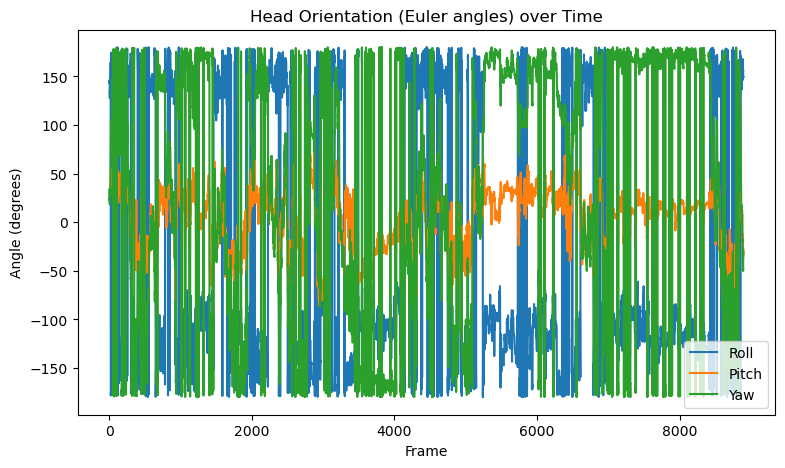

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def rotation_matrix_to_euler(R, sequence='xyz'):
    """
    Convert a 3x3 rotation matrix to Euler angles in a given sequence.
    For example, `sequence='xyz'` means Rz * Ry * Rx, etc.
    
    NOTE: There's no single standard for Euler sequences, so pick carefully.
    """
    # Quick implementation for 'zyx' (roll-pitch-yaw).
    sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6

    if not singular:
        # yaw (around z), pitch (around y), roll (around x)
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = np.arctan2(R[2, 1], R[2, 2])
    else:
        # Handle singular case
        yaw = np.arctan2(-R[1, 2], R[1, 1])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = 0

    return np.array([roll, pitch, yaw])

# Assuming df_test and df_results exist
nf = df_test.shape[0]
global_head_rm = df_results["global_head_rm"]
eulers_over_time = []

for t in range(nf):
    if not np.any(np.isnan(global_head_rm[t, :, :])):  # Skip NaN
        eulers = rotation_matrix_to_euler(global_head_rm[t, :, :], sequence='zyx')
        eulers_over_time.append(eulers)
    else:
        eulers_over_time.append([np.nan, np.nan, np.nan])

# Convert to a NumPy array for easier slicing
eulers_over_time = np.array(eulers_over_time)

# Separate and convert to degrees
rolls = np.degrees(eulers_over_time[:, 0])
pitchs = np.degrees(eulers_over_time[:, 1])
yaws = np.degrees(eulers_over_time[:, 2])

# Plotting
time = np.arange(nf)  # Or actual timestamps if available

plt.figure(figsize=(9, 5))
plt.plot(time, rolls, label='Roll')
plt.plot(time, pitchs, label='Pitch')
plt.plot(time, yaws, label='Yaw')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.title('Head Orientation (Euler angles) over Time')
plt.show()


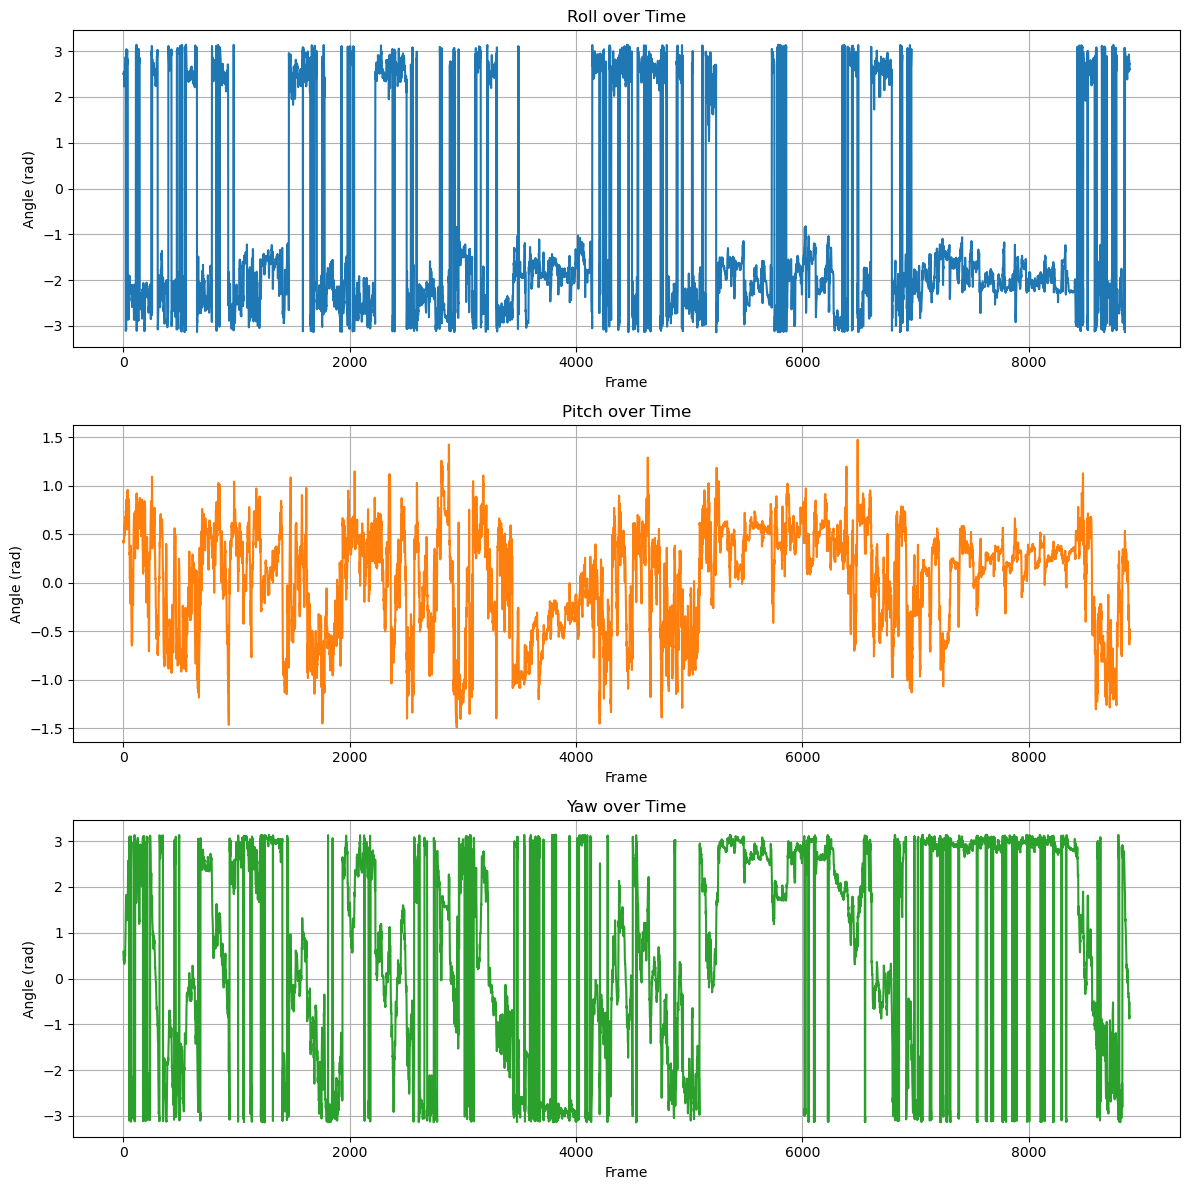

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def rotation_matrix_to_euler(R, sequence='xyz'):
    """
    Convert a 3x3 rotation matrix to Euler angles in a given sequence.
    For example, `sequence='xyz'` means Rz * Ry * Rx, etc.
    
    NOTE: There's no single standard for Euler sequences, so pick carefully.
    """
    sy = np.sqrt(R[0, 0]**2 + R[1, 0]**2)
    singular = sy < 1e-6

    if not singular:
        yaw   = np.arctan2(R[1, 0], R[0, 0])
        pitch = np.arctan2(-R[2, 0], sy)
        roll  = np.arctan2(R[2, 1], R[2, 2])
    else:
        yaw   = np.arctan2(-R[1, 2], R[1, 1])
        pitch = np.arctan2(-R[2, 0], sy)
        roll  = 0

    return np.array([roll, pitch, yaw])

# Example data: Assuming you have the DataFrame and global_head_rm defined.
nf = df_test.shape[0]
global_head_rm = df_results["global_head_rm"]
eulers_over_time = []

for t in range(nf):
    if not np.any(np.isnan(global_head_rm[t, :, :])):  # skip NaN
        eulers = rotation_matrix_to_euler(global_head_rm[t, :, :], sequence='zyx')
        eulers_over_time.append(eulers)
    else:
        eulers_over_time.append([np.nan, np.nan, np.nan])

# Convert to a NumPy array for easier slicing
eulers_over_time = np.array(eulers_over_time)
rolls  = eulers_over_time[:, 0]
pitchs = eulers_over_time[:, 1]
yaws   = eulers_over_time[:, 2]

time = np.arange(nf)  # or actual timestamps if you have them

# Plot each angle on a separate graph
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(time, rolls, label='Roll', color='tab:blue')
plt.xlabel('Frame')
plt.ylabel('Angle (rad)')
plt.title('Roll over Time')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, pitchs, label='Pitch', color='tab:orange')
plt.xlabel('Frame')
plt.ylabel('Angle (rad)')
plt.title('Pitch over Time')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, yaws, label='Yaw', color='tab:green')
plt.xlabel('Frame')
plt.ylabel('Angle (rad)')
plt.title('Yaw over Time')
plt.grid(True)

plt.tight_layout()
plt.show()


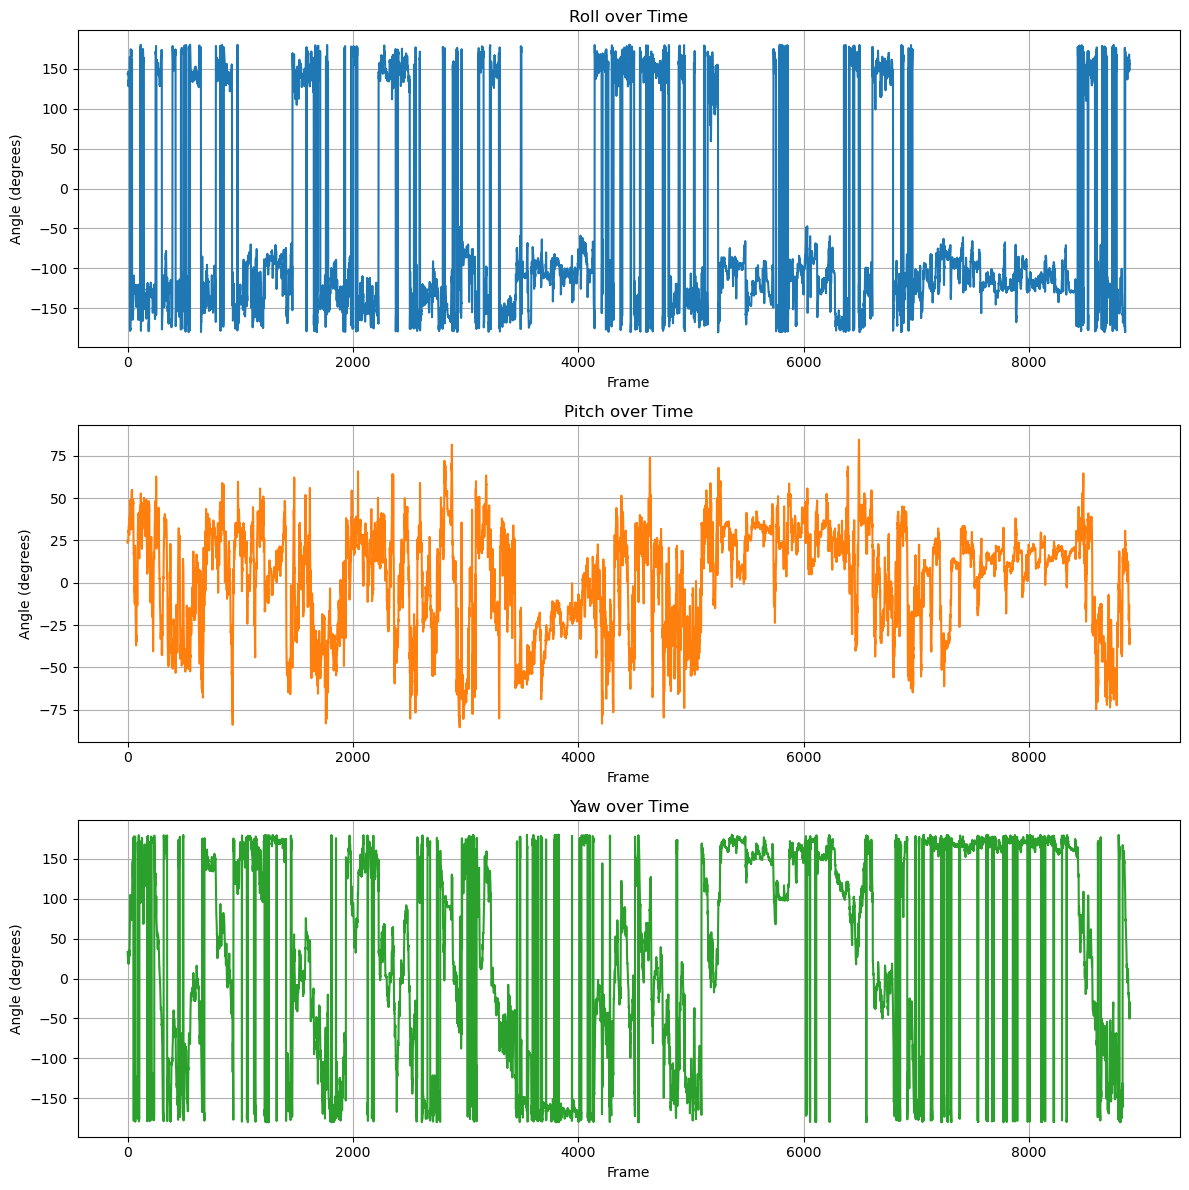

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def rotation_matrix_to_euler(R, sequence='xyz'):
    """
    Convert a 3x3 rotation matrix to Euler angles in a given sequence.
    For example, `sequence='xyz'` means Rz * Ry * Rx, etc.
    
    NOTE: There's no single standard for Euler sequences, so pick carefully.
    """
    sy = np.sqrt(R[0, 0]**2 + R[1, 0]**2)
    singular = sy < 1e-6

    if not singular:
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = np.arctan2(R[2, 1], R[2, 2])
    else:
        yaw = np.arctan2(-R[1, 2], R[1, 1])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = 0

    return np.array([roll, pitch, yaw])

# Assuming df_test and df_results are defined
nf = df_test.shape[0]
global_head_rm = df_results["global_head_rm"]
eulers_over_time = []

for t in range(nf):
    if not np.any(np.isnan(global_head_rm[t, :, :])):  # Skip NaN
        eulers = rotation_matrix_to_euler(global_head_rm[t, :, :], sequence='zyx')
        eulers_over_time.append(eulers)
    else:
        eulers_over_time.append([np.nan, np.nan, np.nan])

# Convert to a NumPy array for easier slicing
eulers_over_time = np.array(eulers_over_time)

# Separate and convert to degrees
rolls = np.degrees(eulers_over_time[:, 0])
pitchs = np.degrees(eulers_over_time[:, 1])
yaws = np.degrees(eulers_over_time[:, 2])

# Plot each angle on a separate graph
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(time, rolls, label='Roll', color='tab:blue')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Roll over Time')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, pitchs, label='Pitch', color='tab:orange')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Pitch over Time')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, yaws, label='Yaw', color='tab:green')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Yaw over Time')
plt.grid(True)

plt.tight_layout()
plt.show()


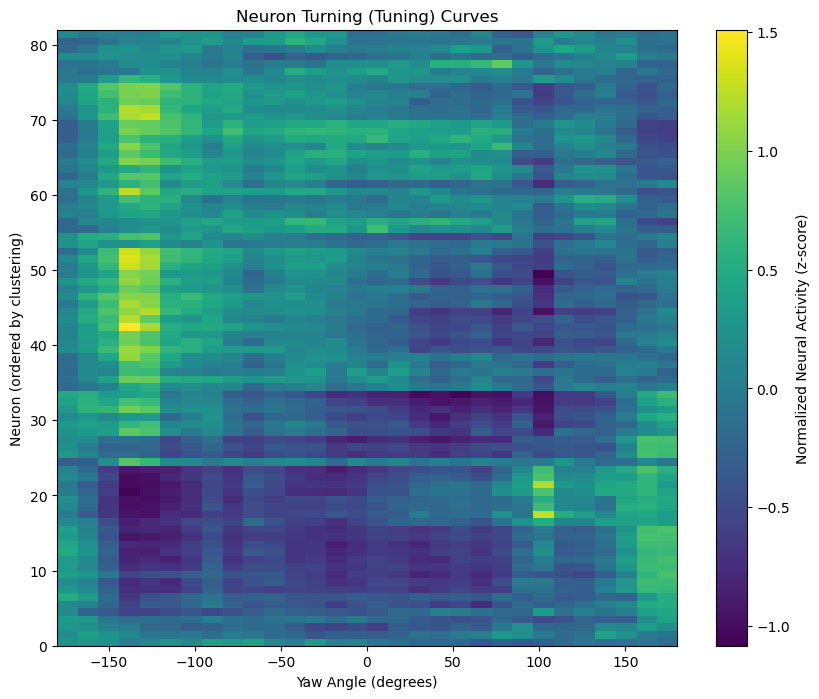

/tmp/ipykernel_1001090/4215464344.py:99: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


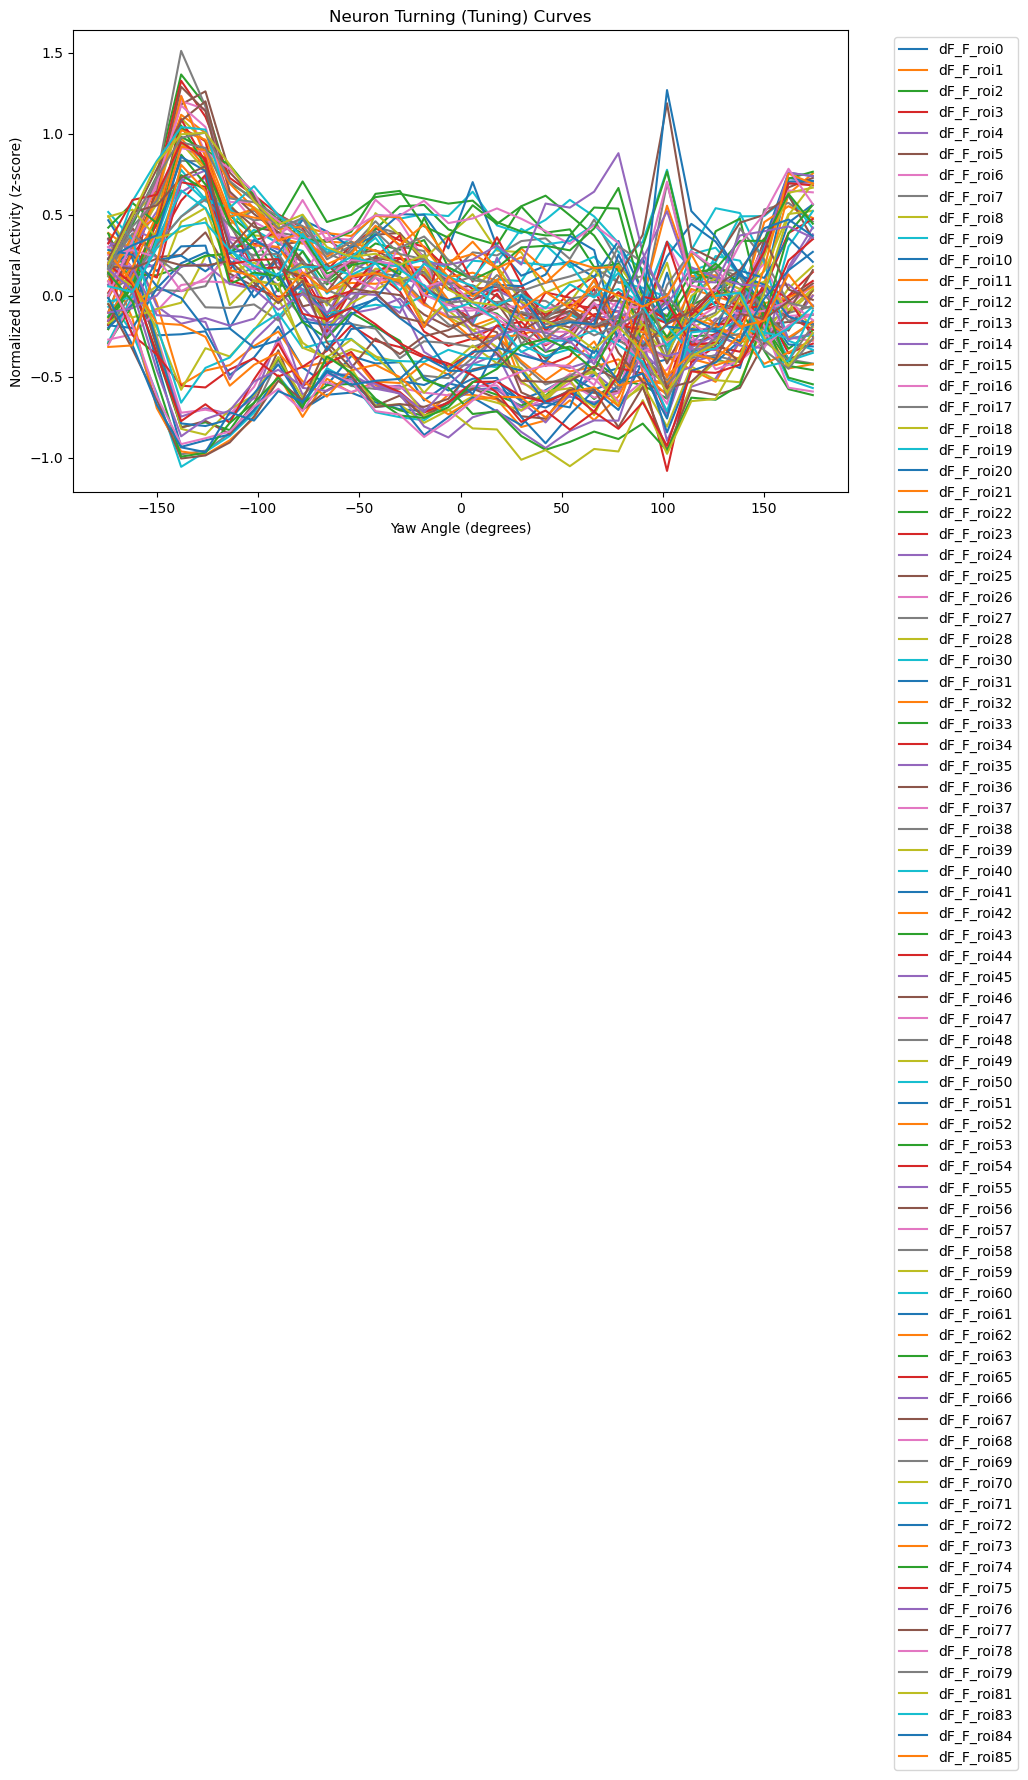

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram

# -----------------------
# LOAD & PREPROCESS NEURON DATA
# -----------------------

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Extract columns that correspond to neurons (assumed to start with 'dF_F_roi')
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
# Shape: (timepoints, neurons)
neuron_activity = df_merged_with_dF_F[neuron_columns].values  
# Transpose so that rows are neurons and columns are timepoints
neuron_activity = neuron_activity.T  

# Drop low-variance neurons (keep roughly top 95% variance)
neuron_variances = np.var(neuron_activity, axis=1)
threshold = np.percentile(neuron_variances, 5)
high_variance_indices = neuron_variances > threshold

# Filter neuron activity and the corresponding column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optionally, perform Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)

# Perform hierarchical clustering (using correlation distance)
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')


# -----------------------
# COMPUTE NEURON TURNING (TUNING) CURVES
# -----------------------

# Here we assume you have already computed head orientation angles in degrees.
# For example, if you previously computed Euler angles, you might use the yaw:
#   yaws = np.degrees(eulers_over_time[:, 2])
# Make sure that yaws is a 1D array with length equal to the number of timepoints.
#
# If you haven't done so yet, compute your yaw angles (in degrees) accordingly.
# (The code below assumes that the variable `yaws` is available.)

# Define the number of bins for yaw
n_bins = 30
# Create bins spanning the range of yaw values
yaw_bins = np.linspace(np.min(yaws), np.max(yaws), n_bins+1)
# Compute the bin centers for plotting
yaw_bin_centers = (yaw_bins[:-1] + yaw_bins[1:]) / 2

# For each neuron, compute the average normalized activity in each yaw bin.
n_neurons = neuron_activity_normalized.shape[0]
neuron_tuning_curves = np.zeros((n_neurons, n_bins))

for j in range(n_bins):
    # Find timepoints where yaw falls in the current bin
    bin_mask = (yaws >= yaw_bins[j]) & (yaws < yaw_bins[j+1])
    if np.sum(bin_mask) > 0:
        # Average over timepoints in this bin for all neurons
        neuron_tuning_curves[:, j] = np.mean(neuron_activity_normalized[:, bin_mask], axis=1)
    else:
        neuron_tuning_curves[:, j] = np.nan

# Reorder neurons based on the clustering dendrogram (optional but often useful)
dendro = dendrogram(Z, no_plot=True)
order = dendro['leaves']
neuron_tuning_curves_ordered = neuron_tuning_curves[order, :]


# -----------------------
# PLOT THE TURNING (TUNING) CURVES
# -----------------------

# Option 1: Heatmap of turning curves (recommended if you have many neurons)
plt.figure(figsize=(10, 8))
plt.imshow(neuron_tuning_curves_ordered, aspect='auto', 
           extent=[yaw_bins[0], yaw_bins[-1], 0, neuron_tuning_curves_ordered.shape[0]], 
           origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Neural Activity (z-score)')
plt.xlabel('Yaw Angle (degrees)')
plt.ylabel('Neuron (ordered by clustering)')
plt.title('Neuron Turning (Tuning) Curves')
plt.show()


# Option 2: Plot individual tuning curves (useful if you have only a few neurons)
plt.figure(figsize=(10, 6))
for i in range(neuron_tuning_curves.shape[0]):
    plt.plot(yaw_bin_centers, neuron_tuning_curves[i, :], label=filtered_neuron_columns[i])
plt.xlabel('Yaw Angle (degrees)')
plt.ylabel('Normalized Neural Activity (z-score)')
plt.title('Neuron Turning (Tuning) Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


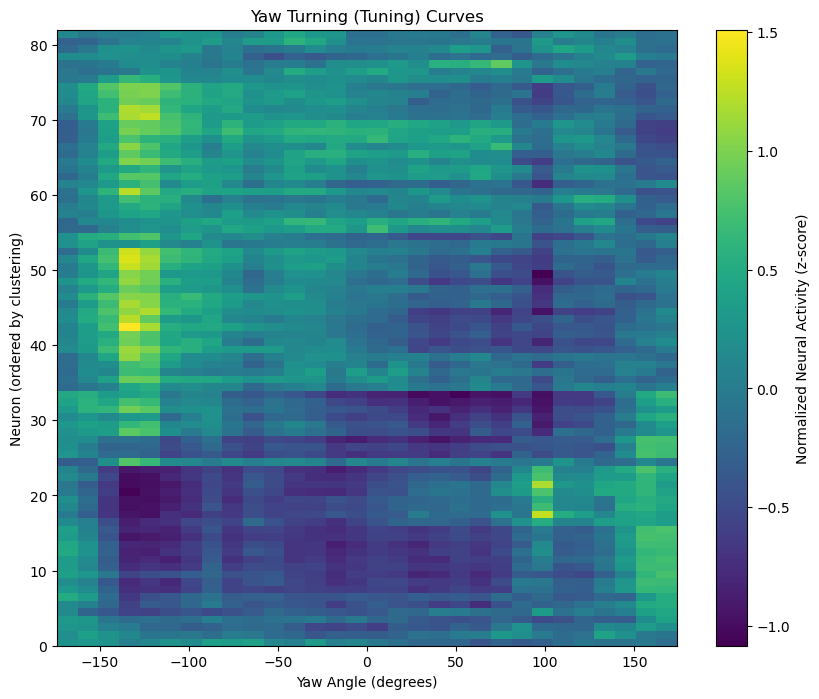

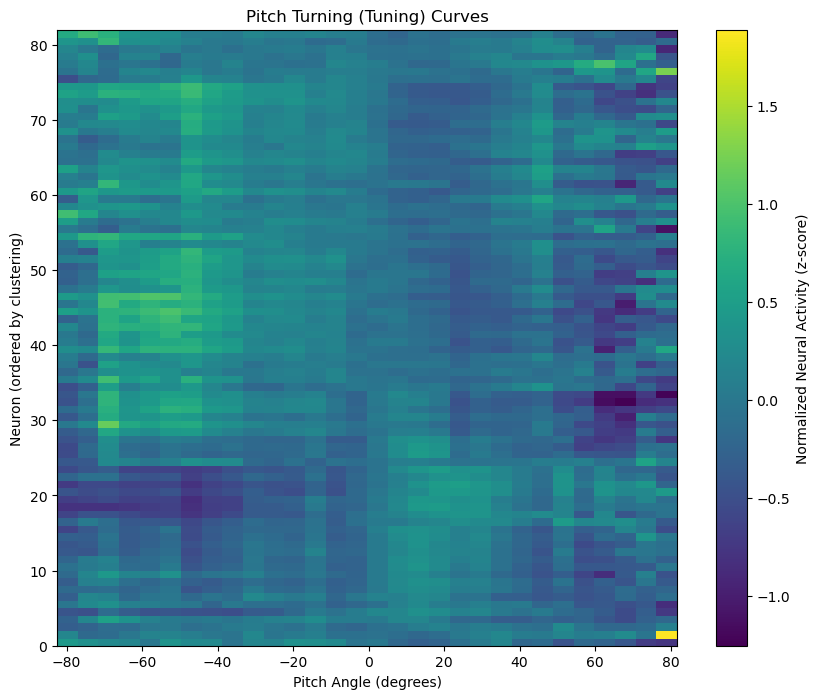

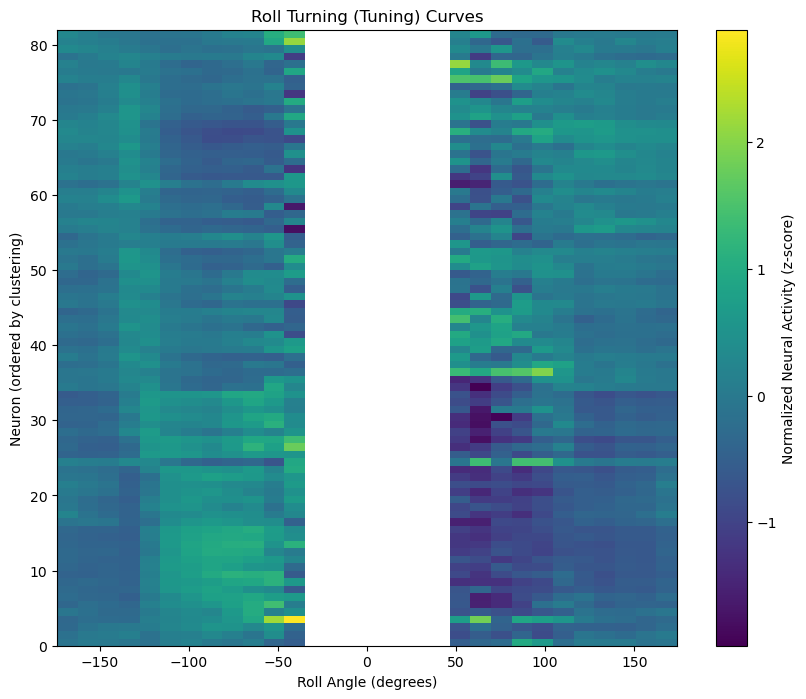

In [13]:
# We assume 'rolls', 'pitchs', and 'yaws' are already defined (each as a 1D array of angles in degrees)

# Function to compute turning curves for any given angle
def compute_tuning_curves(neuron_activity_normalized, angles, n_bins=30):
    # Define bins and bin centers
    angle_bins = np.linspace(np.min(angles), np.max(angles), n_bins + 1)
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

    # Compute tuning curves
    n_neurons = neuron_activity_normalized.shape[0]
    tuning_curves = np.zeros((n_neurons, n_bins))

    for j in range(n_bins):
        bin_mask = (angles >= angle_bins[j]) & (angles < angle_bins[j + 1])
        if np.sum(bin_mask) > 0:
            tuning_curves[:, j] = np.mean(neuron_activity_normalized[:, bin_mask], axis=1)
        else:
            tuning_curves[:, j] = np.nan

    return tuning_curves, bin_centers

# Compute tuning curves for each angle
yaw_tuning_curves, yaw_bin_centers = compute_tuning_curves(neuron_activity_normalized, yaws)
pitch_tuning_curves, pitch_bin_centers = compute_tuning_curves(neuron_activity_normalized, pitchs)
roll_tuning_curves, roll_bin_centers = compute_tuning_curves(neuron_activity_normalized, rolls)

# Reorder neurons by clustering (using the same Z from before)
yaw_tuning_curves_ordered = yaw_tuning_curves[order, :]
pitch_tuning_curves_ordered = pitch_tuning_curves[order, :]
roll_tuning_curves_ordered = roll_tuning_curves[order, :]

# -----------------------
# PLOT THE HEATMAPS
# -----------------------

# Plot yaw tuning curves
plt.figure(figsize=(10, 8))
plt.imshow(yaw_tuning_curves_ordered, aspect='auto', extent=[yaw_bin_centers[0], yaw_bin_centers[-1], 0, yaw_tuning_curves_ordered.shape[0]], origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Neural Activity (z-score)')
plt.xlabel('Yaw Angle (degrees)')
plt.ylabel('Neuron (ordered by clustering)')
plt.title('Yaw Turning (Tuning) Curves')
plt.show()

# Plot pitch tuning curves
plt.figure(figsize=(10, 8))
plt.imshow(pitch_tuning_curves_ordered, aspect='auto', extent=[pitch_bin_centers[0], pitch_bin_centers[-1], 0, pitch_tuning_curves_ordered.shape[0]], origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Neural Activity (z-score)')
plt.xlabel('Pitch Angle (degrees)')
plt.ylabel('Neuron (ordered by clustering)')
plt.title('Pitch Turning (Tuning) Curves')
plt.show()

# Plot roll tuning curves
plt.figure(figsize=(10, 8))
plt.imshow(roll_tuning_curves_ordered, aspect='auto', extent=[roll_bin_centers[0], roll_bin_centers[-1], 0, roll_tuning_curves_ordered.shape[0]], origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Neural Activity (z-score)')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Neuron (ordered by clustering)')
plt.title('Roll Turning (Tuning) Curves')
plt.show()


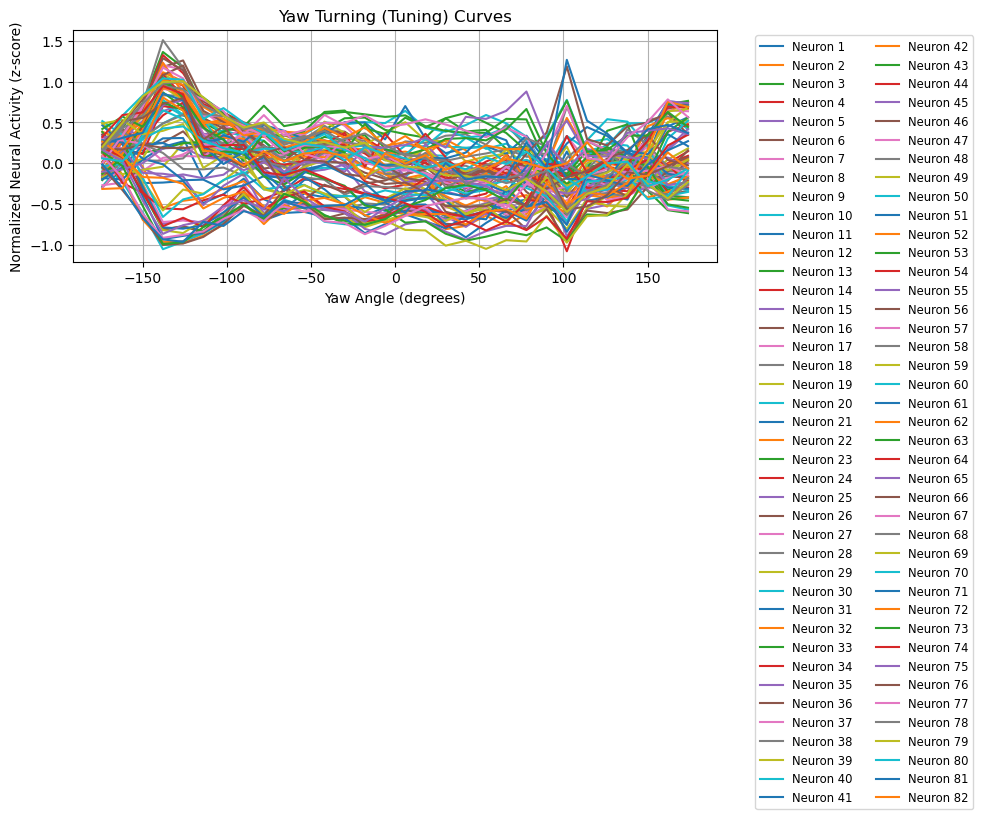

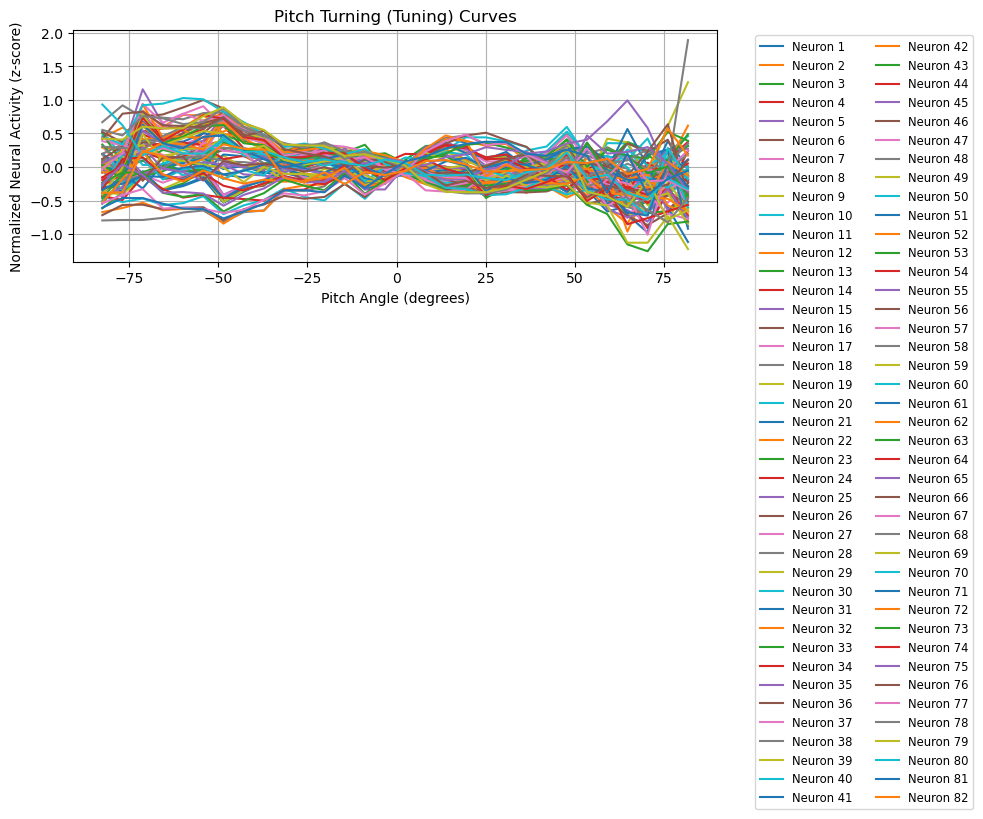

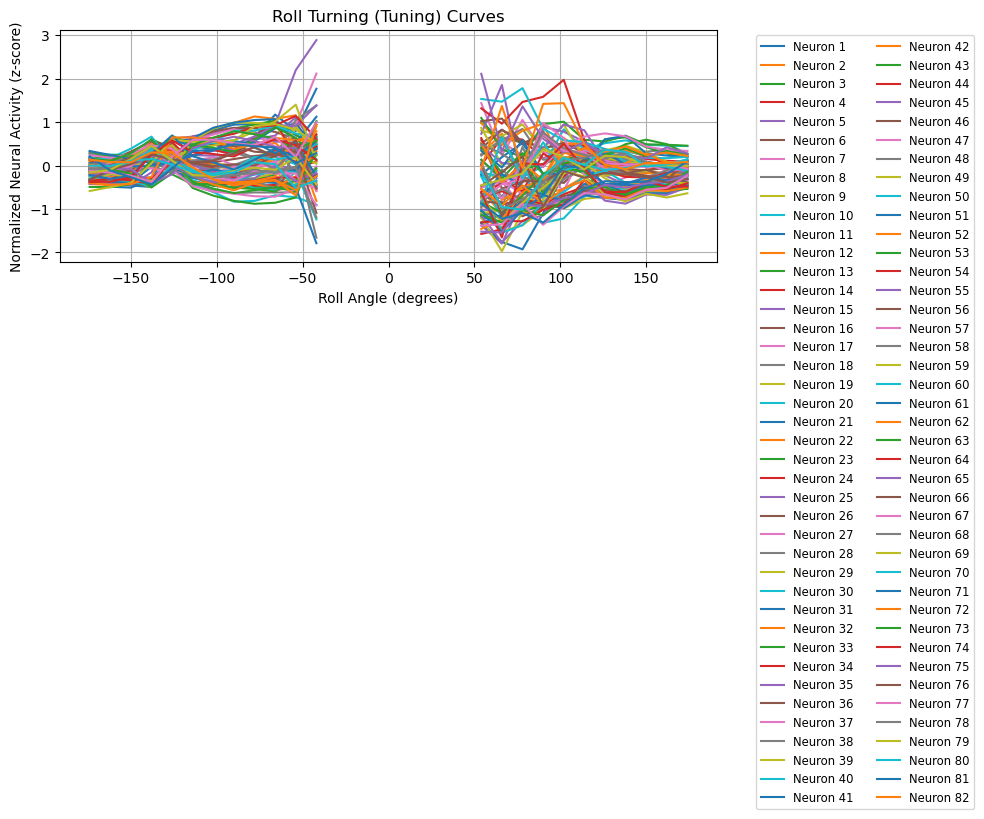

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram

# Assuming you have rolls, pitchs, yaws, and the neuron activity normalized already

# Function to compute tuning curves for any given angle
def compute_tuning_curves(neuron_activity_normalized, angles, n_bins=30):
    angle_bins = np.linspace(np.min(angles), np.max(angles), n_bins + 1)
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

    n_neurons = neuron_activity_normalized.shape[0]
    tuning_curves = np.zeros((n_neurons, n_bins))

    for j in range(n_bins):
        bin_mask = (angles >= angle_bins[j]) & (angles < angle_bins[j + 1])
        if np.sum(bin_mask) > 0:
            tuning_curves[:, j] = np.mean(neuron_activity_normalized[:, bin_mask], axis=1)
        else:
            tuning_curves[:, j] = np.nan

    return tuning_curves, bin_centers

# Compute tuning curves for each angle
yaw_tuning_curves, yaw_bin_centers = compute_tuning_curves(neuron_activity_normalized, yaws)
pitch_tuning_curves, pitch_bin_centers = compute_tuning_curves(neuron_activity_normalized, pitchs)
roll_tuning_curves, roll_bin_centers = compute_tuning_curves(neuron_activity_normalized, rolls)

# -----------------------
# PLOT INDIVIDUAL TUNING CURVES
# -----------------------

# Yaw tuning curves
plt.figure(figsize=(10, 6))
for i in range(yaw_tuning_curves.shape[0]):
    plt.plot(yaw_bin_centers, yaw_tuning_curves[i, :], label=f'Neuron {i+1}')
plt.xlabel('Yaw Angle (degrees)')
plt.ylabel('Normalized Neural Activity (z-score)')
plt.title('Yaw Turning (Tuning) Curves')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# Pitch tuning curves
plt.figure(figsize=(10, 6))
for i in range(pitch_tuning_curves.shape[0]):
    plt.plot(pitch_bin_centers, pitch_tuning_curves[i, :], label=f'Neuron {i+1}')
plt.xlabel('Pitch Angle (degrees)')
plt.ylabel('Normalized Neural Activity (z-score)')
plt.title('Pitch Turning (Tuning) Curves')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# Roll tuning curves
plt.figure(figsize=(10, 6))
for i in range(roll_tuning_curves.shape[0]):
    plt.plot(roll_bin_centers, roll_tuning_curves[i, :], label=f'Neuron {i+1}')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Normalized Neural Activity (z-score)')
plt.title('Roll Turning (Tuning) Curves')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


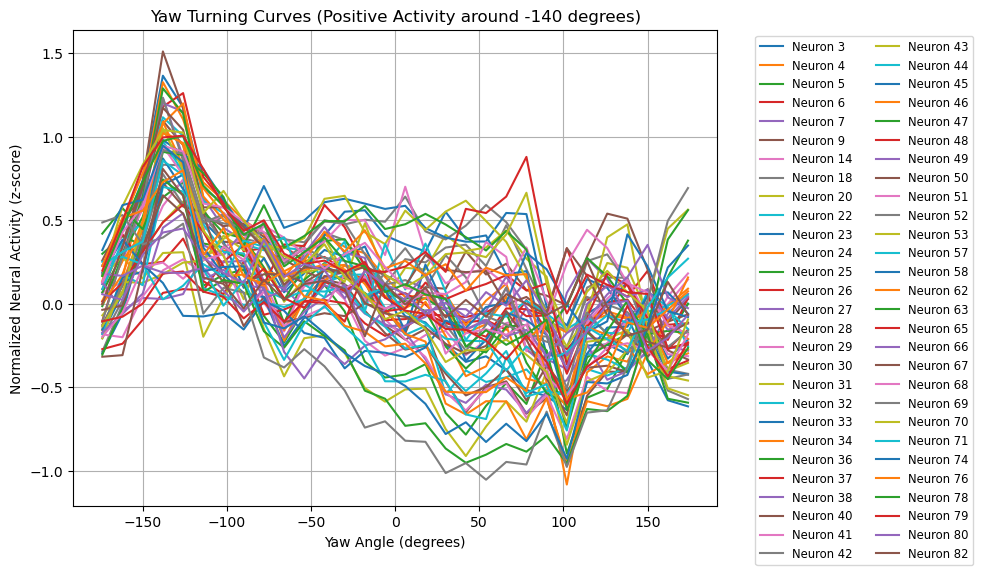

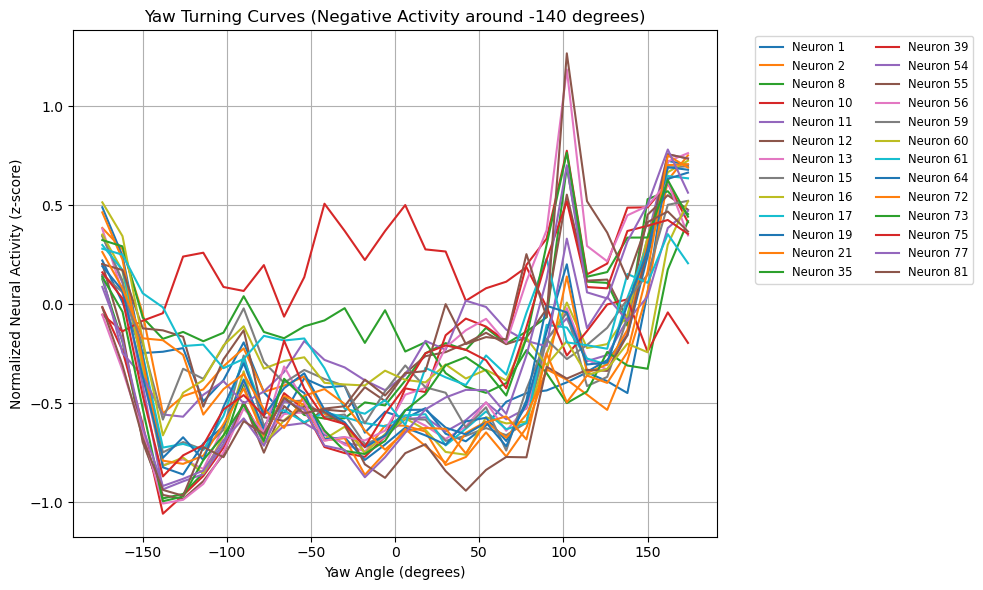

In [15]:
# Define the bin range around -140 degrees
target_angle = -140
bin_tolerance = 10  # ±10 degrees tolerance

# Find the bin index closest to -140 degrees
closest_bin_idx = np.argmin(np.abs(yaw_bin_centers - target_angle))

# Separate neurons into positive and negative groups based on activity at this bin
positive_group = yaw_tuning_curves[:, closest_bin_idx] > 0
negative_group = yaw_tuning_curves[:, closest_bin_idx] <= 0

# -----------------------
# PLOT THE POSITIVE GROUP
# -----------------------
plt.figure(figsize=(10, 6))
for i, is_positive in enumerate(positive_group):
    if is_positive:
        plt.plot(yaw_bin_centers, yaw_tuning_curves[i, :], label=f'Neuron {i+1}')
plt.xlabel('Yaw Angle (degrees)')
plt.ylabel('Normalized Neural Activity (z-score)')
plt.title('Yaw Turning Curves (Positive Activity around -140 degrees)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# -----------------------
# PLOT THE NEGATIVE GROUP
# -----------------------
plt.figure(figsize=(10, 6))
for i, is_negative in enumerate(negative_group):
    if is_negative:
        plt.plot(yaw_bin_centers, yaw_tuning_curves[i, :], label=f'Neuron {i+1}')
plt.xlabel('Yaw Angle (degrees)')
plt.ylabel('Normalized Neural Activity (z-score)')
plt.title('Yaw Turning Curves (Negative Activity around -140 degrees)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [17]:
positive_group_neurons, negative_group_neurons = np.where(positive_group)[0].tolist(), np.where(negative_group)[0].tolist()


In [18]:
positive_group_neurons, negative_group_neurons

([2,
  3,
  4,
  5,
  6,
  8,
  13,
  17,
  19,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  35,
  36,
  37,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  56,
  57,
  61,
  62,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  73,
  75,
  77,
  78,
  79,
  81],
 [0,
  1,
  7,
  9,
  10,
  11,
  12,
  14,
  15,
  16,
  18,
  20,
  34,
  38,
  53,
  54,
  55,
  58,
  59,
  60,
  63,
  71,
  72,
  74,
  76,
  80])